## Importing Libraries

In [2]:
import os
import pandas as pd
import sqlite3
from sqlite3 import Error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Dataset and Visualizing Missing values

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


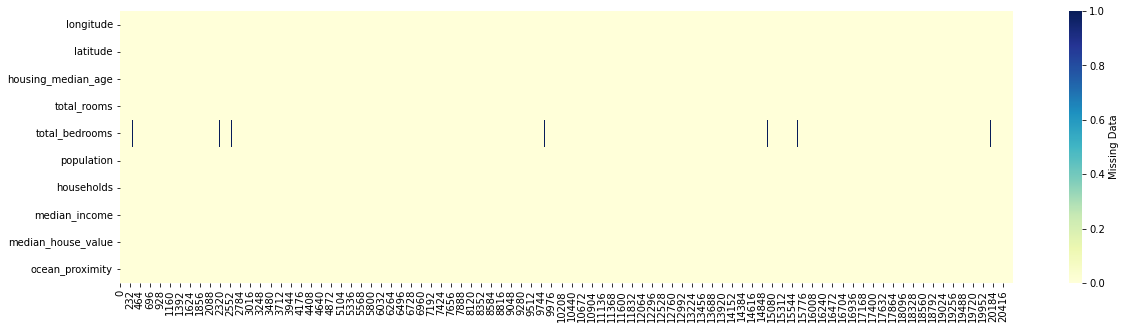

In [5]:
# Importing the dataset
dataset = pd.read_csv("housing.csv")
print(dataset.isnull().sum()) #To check total null values in dataset

#To visualize missing values in heat map seaborn:
plt.figure(figsize=(20,5))
sns.heatmap(dataset.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("heatmap_Seaborn_Python.png", dpi=100)

## Handle the missing values

In [6]:
#Step3: 
#To fill the missing values with mean:
updated_df = dataset
updated_df['total_bedrooms']=updated_df['total_bedrooms'].fillna(updated_df['total_bedrooms'].mean())
updated_df.info() #To see what kind of data each column includes.
print(updated_df.isnull().sum()) #To check total null values in updated_df.
updated_df.describe() #To see how the data is distributed, its size, minimum, mean.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
d

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,419.266592,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,297.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,438.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,643.250000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Creating SQL Database and Generic Functions

In [16]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)
    return conn

normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)

def create_table(conn, create_table_sql, drop_table_name=None):
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    return rows
cur = conn.cursor()

## Creating Tables

### Step 1: Creating Location Table

In [37]:
df = updated_df
location = []
location_ = df[df.columns[0:2]].values.tolist()
for ele in location_:
    if (ele[0], ele[1]) not in location:
        location.append((ele[0], ele[1]))
location_query1 = '''
    CREATE TABLE Location(
        L_ID INTEGER NOT NULL,
        longitude INTEGER NOT NULL,
        latitude INTEGER NOT NULL,
        PRIMARY KEY (L_ID)
    )'''
create_table(conn, location_query1, drop_table_name='Location')
for ele in range(len(location)):
    cur.execute('INSERT INTO Location(longitude, latitude) VALUES(?, ?)', (location[ele][0], location[ele][1]))
conn.commit()

### Step 2: Creating Dictionaries to map:
### Location - Location ID

In [39]:
data_location = execute_sql_statement('SELECT * FROM Location', conn)
location_dict = {(val1, val2):key for key, val1, val2 in data_location}

### Step 3: Creating Housing_Cost Table

In [53]:
housing_cost = df[['longitude', 'latitude', 'housing_median_age', 'median_house_value', 'ocean_proximity']].values.tolist()
housing_cost_query1 = '''
    CREATE TABLE Housing_Cost(
        HC_ID INTEGER NOT NULL,
        L_ID INTEGER NOT NULL,
        housing_median_age INTEGER NOT NULL,
        median_house_value INTEGER NOT NULL,
        ocean_proximity TEXT NOT NULL,
        PRIMARY KEY (HC_ID),
        FOREIGN KEY (L_ID) REFERENCES Location(L_ID)
    )'''
create_table(conn, housing_cost_query1, drop_table_name='Housing_Cost')
for ele in range(len(housing_cost)):
    cur.execute('INSERT INTO Housing_Cost(L_ID, housing_median_age, median_house_value, ocean_proximity) VALUES(?, ?, ?, ?)', (location_dict[(housing_cost[ele][0], housing_cost[ele][1])], housing_cost[ele][2], housing_cost[ele][3], housing_cost[ele][4]))
conn.commit()    

### Step 4: Creating Housing_Structure Table

In [54]:
housing_structure = df[['longitude', 'latitude', 'total_rooms', 'total_bedrooms']].values.tolist()
housing_structure_query1 = '''
    CREATE TABLE Housing_Structure(
        HS_ID INTEGER NOT NULL,
        L_ID INTEGER NOT NULL,
        total_rooms INTEGER NOT NULL,
        total_bedrooms INTEGER NOT NULL,
        PRIMARY KEY (HS_ID),
        FOREIGN KEY (L_ID) REFERENCES Location(L_ID)
    )'''
create_table(conn, housing_structure_query1, drop_table_name='Housing_Structure')
for ele in range(len(housing_structure)):
    cur.execute('INSERT INTO Housing_Structure(L_ID, total_rooms, total_bedrooms) VALUES(?, ?, ?)', (location_dict[(housing_structure[ele][0], housing_structure[ele][1])], housing_structure[ele][2], housing_structure[ele][3]))
conn.commit()    

### Step 5: Creating Population Table

In [56]:
population = df[['longitude', 'latitude', 'population']].values.tolist()
population_query1 = '''
    CREATE TABLE Population(
        P_ID INTEGER NOT NULL,
        L_ID INTEGER NOT NULL,
        population INTEGER NOT NULL,
        PRIMARY KEY (P_ID),
        FOREIGN KEY (L_ID) REFERENCES Location(L_ID)
    )'''
create_table(conn, population_query1, drop_table_name='Population')
for ele in range(len(population)):
    cur.execute('INSERT INTO Population(L_ID, population) VALUES(?, ?)', (location_dict[(population[ele][0], population[ele][1])], population[ele][2]))
conn.commit()    

### Step 6: Creating Household Table

In [59]:
households = df[['longitude', 'latitude', 'households', 'median_income']].values.tolist()
households_query1 = '''
    CREATE TABLE Households(
        HH_ID INTEGER NOT NULL,
        L_ID INTEGER NOT NULL,
        households INTEGER NOT NULL,
        PRIMARY KEY (HH_ID),
        FOREIGN KEY (L_ID) REFERENCES Location(L_ID)
    )'''
create_table(conn, households_query1, drop_table_name='Households')
for ele in range(len(households)):
    cur.execute('INSERT INTO Households(L_ID, households) VALUES(?, ?)', (location_dict[(households[ele][0], households[ele][1])], households[ele][2]))
conn.commit()    

## Visualisations

### House Value Heatmap in California

In [129]:
#locations_geo = df[['longitude', 'latitude']].values.tolist()
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="Mine")
#county = []
#for ele in locations_geo[0:20640:100]:
#    string = str(str(ele[1]) + ', ' + str(ele[0]))
#    #print(string)
#    location = geolocator.reverse(string)
#    if location.raw['address']['county'] not in county:
#        county.append(location.raw['address']['county'])
#print(county)